## Add Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import splitfolders
import os
import shutil

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.applications import VGG16

## Read In Data

In [2]:
df = pd.read_csv("data/pokedex.csv", index_col=0)
df

,dex_no,image,name,type1,type2,image_name
0,1,https://img.pokemondb.net/sprites/home/normal/...,Bulbasaur,Grass,Poison,bulbasaur.jpg
1,2,https://img.pokemondb.net/sprites/home/normal/...,Ivysaur,Grass,Poison,ivysaur.jpg
2,3,https://img.pokemondb.net/sprites/home/normal/...,Venusaur,Grass,Poison,venusaur.jpg
3,4,https://img.pokemondb.net/sprites/home/normal/...,Charmander,Fire,NaN,charmander.jpg
4,5,https://img.pokemondb.net/sprites/home/normal/...,Charmeleon,Fire,NaN,charmeleon.jpg
...,...,...,...,...,...,...
1005,1006,https://img.pokemondb.net/sprites/scarlet-viol...,Iron Valiant,Fairy,Fighting,iron-valiant.png
1006,1007,https://img.pokemondb.net/sprites/scarlet-viol...,Koraidon,Fighting,Dragon,koraidon.png
1007,1008,https://img.pokemondb.net/sprites/scarlet-viol...,Miraidon,Electric,Dragon,miraidon.png
1008,1009,https://img.pokemondb.net/sprites/scarlet-viol...,Walking Wake,Water,Dragon,walking-wake.png


## Split Folders for Train-Test and By Class

In [48]:
# create train-test-validation folders
splitfolders.ratio('data', output="train_test_folders", seed=1337, ratio=(.8, 0.1,0.1)) 

# add images to folders
train_list = []
for image in os.listdir("train_test_folders/train/images"):
    train_list.append(image)
    
test_list = []
for image in os.listdir("train_test_folders/test/images"):
    test_list.append(image)
    
val_list = []
for image in os.listdir("train_test_folders/val/images"):
    val_list.append(image)
    
# note in dataframe which folder image is in
train_df = df.loc[df.apply(lambda row: row["image_name"] in train_list, axis=1)]
test_df = df.loc[df.apply(lambda row: row["image_name"] in test_list, axis=1)]
val_df = df.loc[df.apply(lambda row: row["image_name"] in val_list, axis=1)]

train_df["split"] = "train"
test_df["split"] = "test"
val_df["split"] = "val"

pdList = [train_df, test_df, val_df]
df = pd.concat(pdList)
df

In [58]:
# add class folders and organize images
train_dir = 'train_test_folders/train/images'
test_dir = 'train_test_folders/test/images'
val_dir = 'train_test_folders/val/images'

for index, row in df.iterrows():
    class_label = row['type1']  
    filename = row['image_name']  
    if class_label not in os.listdir(train_dir):
        os.mkdir(os.path.join(train_dir, class_label))
    if class_label not in os.listdir(test_dir):
        os.mkdir(os.path.join(test_dir, class_label))
    if class_label not in os.listdir(val_dir):
        os.mkdir(os.path.join(val_dir, class_label))       
    if row['split'] == 'train':
        shutil.move(os.path.join(train_dir, filename), os.path.join(train_dir, class_label, filename))
    elif row['split'] == 'test':
        shutil.move(os.path.join(test_dir, filename), os.path.join(test_dir, class_label, filename))
    elif row['split'] == 'val':
        shutil.move(os.path.join(val_dir, filename), os.path.join(val_dir, class_label, filename))

In [6]:
# create generators
train_path = "train_test_folders/train/images"
test_path = "train_test_folders/test/images"
val_path = "train_test_folders/val/images"

data_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_generator = data_gen.flow_from_directory(train_path, target_size=(224, 224), color_mode='rgb', 
                                                    batch_size=5, class_mode='categorical')

test_generator = data_gen.flow_from_directory(test_path, target_size=(224, 224), batch_size=5,
                                             class_mode='categorical')

val_generator = data_gen.flow_from_directory(val_path, target_size=(224, 224), batch_size=5,
                                             class_mode='categorical')

Found 808 images belonging to 18 classes.
Found 101 images belonging to 18 classes.
Found 101 images belonging to 18 classes.


## Base Model

In [3]:
model = Sequential()
# define 3x3 filter window sizes. Create 32 filters.
# COv2D input shape =(image_height, image_width, color_channels) for each image
model.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(28, 28, 1)))
# max pool in 2x2 window
model.add(MaxPooling2D(pool_size=(2, 2)))
# define 3x3 filter window sizes. Create 64 filters.
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

# transition to dense fully-connected part of network
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

Metal device set to: Apple M1 Pro


2023-03-24 15:38:31.631137: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-24 15:38:31.631351: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

In [ ]:
base_model = model.fit(
        train_generator,
        steps_per_epoch=100, verbose = 2, validation_data = test_generator, 
        epochs=10)

Epoch 1/10


In [117]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(18, activation='softmax'))

In [118]:
bce = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])

In [121]:
base_model = model.fit(
        train_generator,
        steps_per_epoch=100, verbose = 2, validation_data = test_generator, 
        epochs=10)

Epoch 1/10
100/100 - 9s - loss: 0.1628 - accuracy: 0.4580 - val_loss: 0.2284 - val_accuracy: 0.1980 - 9s/epoch - 85ms/step
Epoch 2/10
100/100 - 8s - loss: 0.1447 - accuracy: 0.5482 - val_loss: 0.2271 - val_accuracy: 0.2574 - 8s/epoch - 84ms/step
Epoch 3/10
100/100 - 8s - loss: 0.1431 - accuracy: 0.5843 - val_loss: 0.2453 - val_accuracy: 0.2079 - 8s/epoch - 84ms/step
Epoch 4/10
100/100 - 8s - loss: 0.1167 - accuracy: 0.7229 - val_loss: 0.2543 - val_accuracy: 0.2277 - 8s/epoch - 84ms/step
Epoch 5/10
100/100 - 8s - loss: 0.0944 - accuracy: 0.7892 - val_loss: 0.2758 - val_accuracy: 0.2574 - 8s/epoch - 84ms/step
Epoch 6/10
100/100 - 8s - loss: 0.0878 - accuracy: 0.8140 - val_loss: 0.2575 - val_accuracy: 0.2277 - 8s/epoch - 84ms/step
Epoch 7/10
100/100 - 9s - loss: 0.0799 - accuracy: 0.8454 - val_loss: 0.2653 - val_accuracy: 0.2574 - 9s/epoch - 85ms/step
Epoch 8/10
100/100 - 8s - loss: 0.0715 - accuracy: 0.8675 - val_loss: 0.2684 - val_accuracy: 0.2772 - 8s/epoch - 84ms/step
Epoch 9/10
100/1

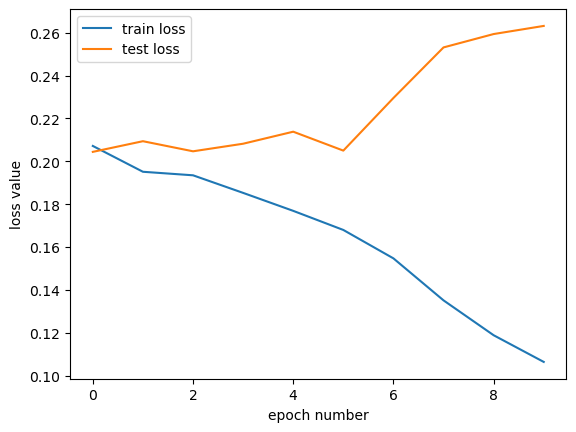

In [99]:
plt.plot(base_model.history["loss"], label = "train loss");
plt.plot(base_model.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

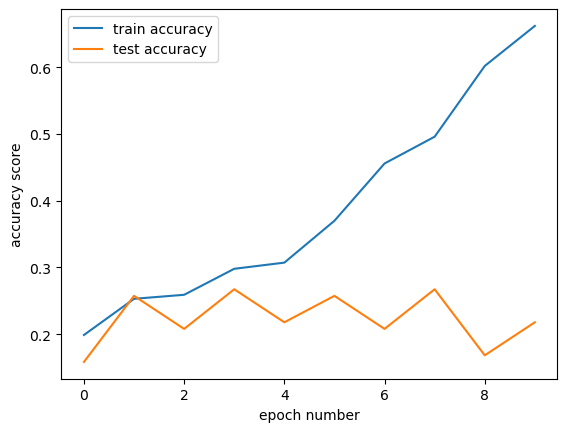

In [100]:
plt.plot(base_model.history["accuracy"], label = "train accuracy");
plt.plot(base_model.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 2

In [101]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(18, activation='softmax'))
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])
model_2 = model.fit(
        train_generator,
        steps_per_epoch=10, verbose=0, validation_data = test_generator, 
        epochs=20)

2023-03-24 15:26:14.062249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-24 15:26:14.866722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


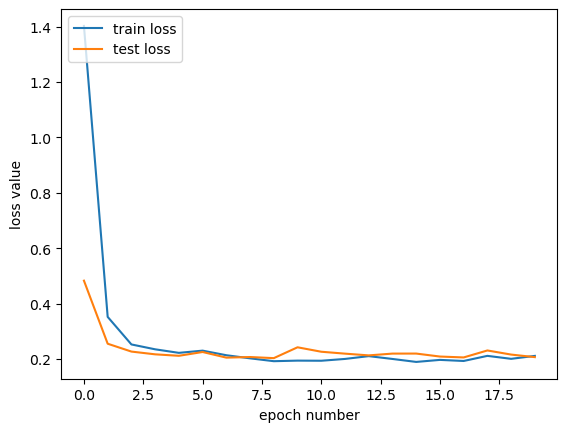

In [103]:
plt.plot(model_2.history["loss"], label = "train loss");
plt.plot(model_2.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

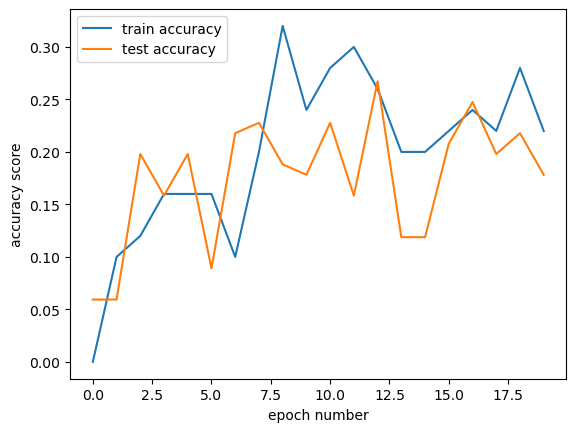

In [104]:
plt.plot(model_2.history["accuracy"], label = "train accuracy");
plt.plot(model_2.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 3

In [106]:
model_3 = model.fit(
        train_generator,
        steps_per_epoch=5, verbose = 0, validation_data = test_generator, 
        epochs=50)

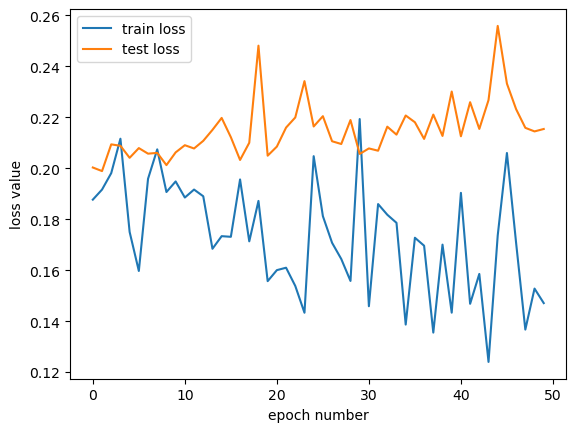

In [107]:
plt.plot(model_3.history["loss"], label = "train loss");
plt.plot(model_3.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

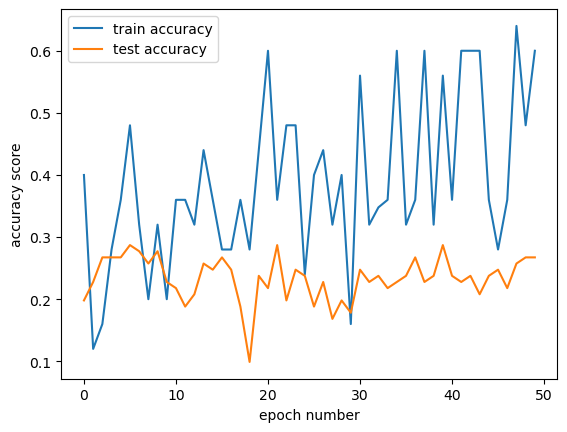

In [108]:
plt.plot(model_3.history["accuracy"], label = "train accuracy");
plt.plot(model_3.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 4

In [112]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(18, activation='softmax'))
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])
model_4 = model.fit(
        train_generator,
        steps_per_epoch=10, verbose=0, validation_data = test_generator, 
        epochs=30)

2023-03-24 15:29:24.817445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-24 15:29:25.666709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


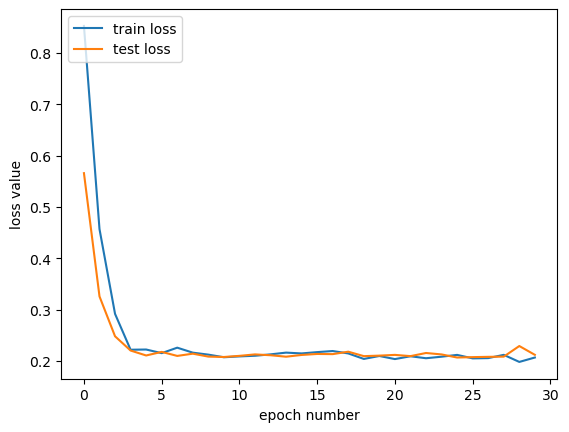

In [113]:
plt.plot(model_4.history["loss"], label = "train loss");
plt.plot(model_4.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

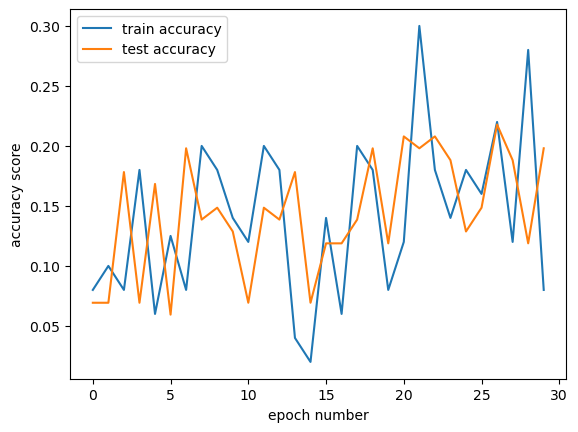

In [114]:
plt.plot(model_4.history["accuracy"], label = "train accuracy");
plt.plot(model_4.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");